https://medium.com/machine-learning-world/tutorial-counting-road-traffic-capacity-with-opencv-998580f1fbde
https://github.com/creotiv/object_detection_projects/tree/master/opencv_traffic_capacity_counting

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
from tqdm import tqdm_notebook as tqdm
import time

%matplotlib inline

In [99]:
# Parameters
input_video_path = './examples/AB17-0830H.avi'
target_frame = 10 

video = cv.VideoCapture(input_video_path)
count = 0

while count < target_frame:
    ret, sample_frame = video.read()
    if ret: 
        count += 1
    else:
        break

video.release()

img_height = sample_frame.shape[0]
img_width = sample_frame.shape[1]

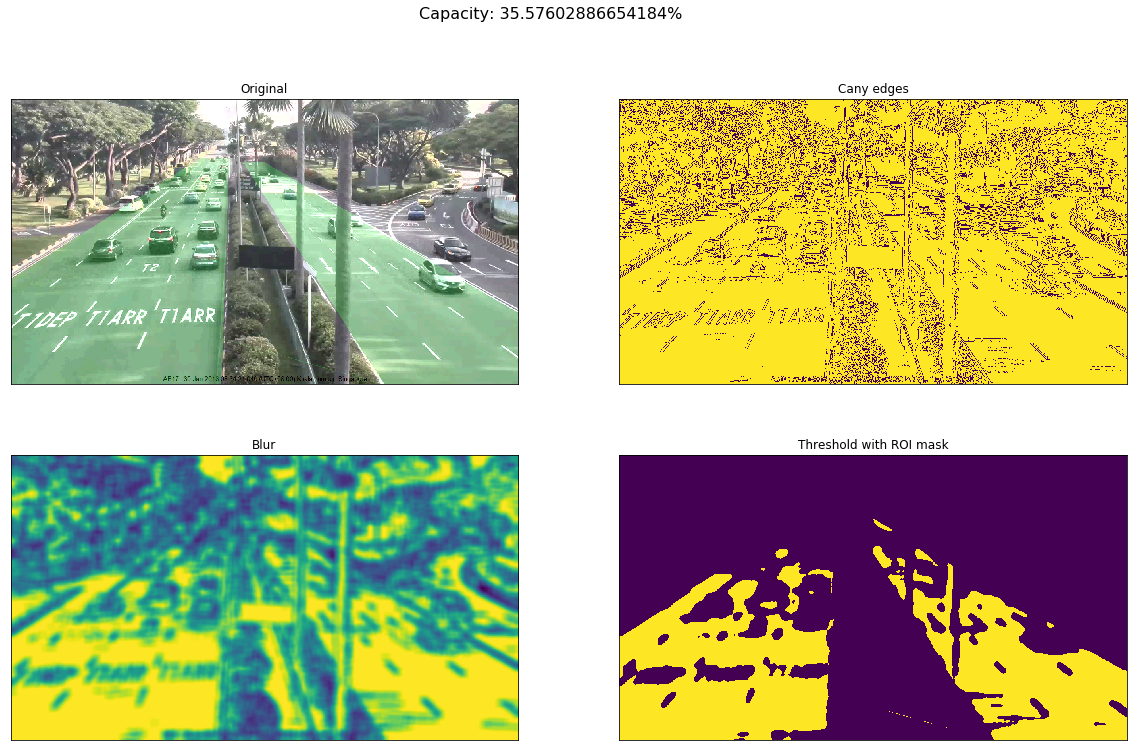

In [145]:
AREA_PTS = np.array([
    [0, 456], [477, 151], [549, 151], [529, 719], [0, 719], [0, 456],
    [937, 720], [585, 161], [638, 161], [1279, 540], [1279, 719], [937, 720]
]) 
base_frame = cv.cvtColor(sample_frame, cv.COLOR_BGR2RGB)
area_mask = cv.fillPoly(np.zeros(base_frame.shape, base_frame.dtype), 
                        [AREA_PTS], 
                        (255, 255, 255)
                       )[:, :, 0]

# CLAHE (Contrast Limited Adaptive Histogram Equalization)
# this used for noise reduction at night time
frame = cv.cvtColor(base_frame, cv.COLOR_RGB2GRAY)
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(frame)

# getting edges with Canny filter
edges = cv.Canny(frame,50,70)
# invert them to get white background
edges = ~edges

# blur with additional use of bilateralFilter to remove color noise
blur = cv.bilateralFilter(cv.blur(edges,(21,21), 100),9,200,200)

# threshold with ROI overlapping
_, threshold = cv.threshold(blur,230, 255,cv.THRESH_BINARY)
t = cv.bitwise_and(threshold, threshold, mask = area_mask)

# counting capacity area
free = np.count_nonzero(t)
capacity = 1 - float(free)/np.count_nonzero(area_mask)

# creating plot for debugging and visualization
img = np.zeros(base_frame.shape, base_frame.dtype)
img[:, :] = (0, 50, 0)
mask = cv.bitwise_and(img, img, mask=area_mask)
cv.addWeighted(mask, 1, base_frame, 1, 0, base_frame)

fig = plt.figure(figsize=(20,12))
fig.suptitle("Capacity: {}%".format(capacity*100), fontsize=16)
plt.subplot(221),plt.imshow(base_frame),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(222),plt.imshow(edges),plt.title('Cany edges')
plt.xticks([]), plt.yticks([])
plt.subplot(223),plt.imshow(blur),plt.title('Blur')
plt.xticks([]), plt.yticks([])
plt.subplot(224),plt.imshow(t),plt.title('Threshold with ROI mask')
plt.xticks([]), plt.yticks([])

plt.show()

In [140]:
cv.imwrite("sampleframe.jpg", sample_frame)

True